In [2]:
import time
import re
import csv
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys as sys
import logging
from datetime import datetime, timedelta, date
import sys
from datetime import datetime
from tqdm import tqdm  # plain-text tqdm

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, unquote

In [ ]:
# Read comment file

comments_merge=pd.read_parquet("projects/SMDA_project/data/comments_merge.parquet")

In [ ]:
# User-level LLM assessor
import os, json, re, math, time, uuid, shutil, subprocess, textwrap
import pandas as pd
from tqdm.notebook import tqdm  

os.environ["OLLAMA_BIN"] = os.path.expanduser("~/ollama/bin/ollama")
os.environ["OLLAMA_HOST"] = "127.0.0.1:11434"
os.environ["OLLAMA_NUM_CTX"] = "4096"
os.environ["OLLAMA_KEEP_ALIVE"] = "5m"

# Pick local instruction model 
OLLAMA_MODEL = "qwen2.5:14b-instruct-q4_K_M"

# How many comments per user to pass to the LLM 
K_PER_USER = 12
MAX_COMMENT_CHARS = 320
MAX_TITLE_CHARS = 140
MAX_DESC_CHARS = 220

def clean_text(t: str) -> str:
    if not t:
        return ""
    t = re.sub(r"<br\s*/?>", " ", str(t), flags=re.I)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def _shorten(s: str, n: int) -> str:
    s = clean_text(s)
    return (s[: n-1] + "…") if len(s) > n else s

def _row_to_lines(row: dict,
                  include_channel_leaning: bool = True,
                  comment_lookup: dict[str, str] | None = None,
                  reply_lookup: dict[tuple[str, str], list[tuple[pd.Timestamp, str]]] | None = None) -> list[str]:
    """
    Build context lines for one comment, including parent replies and @mentions.
    - comment_lookup: maps comment_id → comment_text for parent comments.
    - reply_lookup: maps (video_id, author_display_name) → list of (timestamp, comment_text),
      with author_display_name stripped of "@" and lowercased.
    """
    lines = []

    if include_channel_leaning and row.get("leaning"):
        lines.append(f"Politische Position des Kanals: {clean_text(row['leaning'])}")

    if row.get("video_title"):
        lines.append(f"Video-Titel: {_shorten(row['video_title'], MAX_TITLE_CHARS)}")

    if row.get("description"):
        lines.append(f"Video-Beschreibung: {_shorten(row['description'], MAX_DESC_CHARS)}")

    # Parent comment context
    parent_id = row.get("parent_comment_id")
    if comment_lookup and parent_id and parent_id in comment_lookup:
        parent_text = clean_text(comment_lookup[parent_id])
        if parent_text:
            lines.append(f"Antwort auf: »{_shorten(parent_text, MAX_COMMENT_CHARS)}«")

    #  @mention context 
    comment_txt = row.get("comment_text", "")
    mention_match = re.search(r"@{1,2}([A-Za-z0-9._\-]+)", comment_txt)
    if mention_match and reply_lookup:
        mentioned_name = mention_match.group(1).lstrip("@").lower().strip()
        vid = row.get("video_id")
        timestamp = pd.to_datetime(row.get("published_at"), errors="coerce")
        if vid and mentioned_name and timestamp:
            key = (vid, mentioned_name)
            possible_replies = reply_lookup.get(key, [])
            # Find latest comment from mentioned user before this one
            past_comments = [txt for ts, txt in possible_replies if ts < timestamp]
            if past_comments:
                reply_text = clean_text(past_comments[-1])
                lines.append(f"(Antwort an @{mentioned_name}: »{_shorten(reply_text, MAX_COMMENT_CHARS)}«)")

    # Main comment
    if row.get("comment_text"):
        lines.append(f"Kommentar von User: *{_shorten(row['comment_text'], MAX_COMMENT_CHARS)}*")

    return lines



def _make_user_prompt(rows: list[dict],
                      include_channel_leaning: bool,
                      comment_lookup: dict[str, str],
                      reply_lookup: dict[tuple[str, str], list[tuple[pd.Timestamp, str]]]) -> str:
    rows = sorted(rows, key=lambda r: len(clean_text(r.get("comment_text", ""))), reverse=True)[:K_PER_USER]

    bullets = []
    for i, r in enumerate(rows, 1):
        part = "\n".join(_row_to_lines(r,
                                       include_channel_leaning=include_channel_leaning,
                                       comment_lookup=comment_lookup,
                                       reply_lookup=reply_lookup))
        bullets.append(f"{i}) {part}")

    comments_block = textwrap.indent("\n\n".join(bullets), "  ")

    user_prompt = f"""
Klassifiziere die politische Ausrichtung dieses Nutzers als genau EINES von:
"links", "mitte" oder "rechts".

Regeln:
- Berücksichtige den Kontext (Kanal/Video), aber entscheide nach dem Gesamtbild über alle Kommentare.
- Antworte NUR als JSON: {{ "label": "links|mitte|rechts", "confidence": 0..1 }}
- Keine Erklärungen, kein Fließtext, keine zusätzlichen Felder.

Kommentare (gebündelt):
{comments_block}
""".strip()

    sys_prompt = (
        "You are a concise political stance classifier for German text. "
        "Return ONLY a single JSON object with keys 'label' and 'confidence'. "
        "No prose. No markdown. No additional fields. No explanations."
    )
    return f"<|system|>\n{sys_prompt}\n<|user|>\n{user_prompt}\n<|assistant|>"



# JSON extraction
def _extract_json_balanced(s: str) -> dict:
    """Return the last complete JSON object found in s by balancing braces (handles extra text)."""
    in_str = False
    esc = False
    depth = 0
    start = None
    last_obj = None
    for i, ch in enumerate(s):
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":  # escape start
                esc = True
            elif ch == '"':
                in_str = False
            continue
        else:
            if ch == '"':
                in_str = True
                continue
            if ch == "{":
                if depth == 0:
                    start = i
                depth += 1
            elif ch == "}":
                if depth > 0:
                    depth -= 1
                    if depth == 0 and start is not None:
                        try:
                            last_obj = json.loads(s[start:i+1])
                        except Exception:
                            pass
    if last_obj is None:
        raise ValueError("No JSON object found")
    return last_obj

# Ollama runner with retries + timeout
def _run_ollama_json(prompt: str,
                     model: str = OLLAMA_MODEL,
                     max_retries: int = 3,
                     timeout_sec: int = 120,
                     log_failures_to: str | None = "ollama_failures.log") -> dict:
    """
    Runs `<OLLAMA_BIN> run <model>` and returns parsed JSON dict.
    Retries on failures with exponential backoff and logs failures.
    """
    bin_path = os.environ.get("OLLAMA_BIN") or shutil.which("ollama")
    if not bin_path:
        raise FileNotFoundError("Ollama binary not found. Set OLLAMA_BIN, e.g. ~/ollama/bin/ollama")

    env = os.environ.copy()
    env.setdefault("OLLAMA_NUM_CTX", "4096")
    env.setdefault("OLLAMA_KEEP_ALIVE", "5m")
    cmd = [bin_path, "run", model]
    
    last_err = None

    for attempt in range(1, max_retries + 1):
        try:
            proc = subprocess.run(
                cmd,
                input=prompt,
                capture_output=True,
                text=True,
                env=env,
                timeout=timeout_sec
            )
            if proc.returncode != 0:
                raise RuntimeError(proc.stderr.strip() or f"non-zero exit ({proc.returncode})")
            out = proc.stdout or ""
            return _extract_json_balanced(out)
        except Exception as e:
            last_err = e
            if log_failures_to:
                with open(log_failures_to, "a", encoding="utf-8") as f:
                    rid = uuid.uuid4().hex[:8]
                    f.write(f"\n=== FAIL {rid} attempt {attempt}/{max_retries} ===\n")
                    f.write(f"ERROR: {type(e).__name__}: {e}\n")
                    f.write("PROMPT (first 1000 chars):\n")
                    f.write(prompt[:1000] + ("\n...[truncated]...\n" if len(prompt) > 1000 else "\n"))
                    if 'proc' in locals():
                        f.write("STDOUT (first 1000 chars):\n")
                        f.write((proc.stdout or "")[:1000] + "\n")
                        f.write("STDERR:\n")
                        f.write((proc.stderr or "") + "\n")
            if attempt < max_retries:
                time.sleep(0.8 * (1.8 ** (attempt - 1)))  # exponential backoff
    raise last_err

# Public API 
def llm_label_user(rows_for_user,
                   include_channel_leaning: bool = True,
                   fallback_center_on_parse: bool = True,
                   comment_lookup: dict[str, str] | None = None,
                   reply_lookup: dict[tuple[str, str], list[tuple[pd.Timestamp, str]]] | None = None) -> tuple[str, float]:
    if isinstance(rows_for_user, pd.DataFrame):
        rows_for_user = rows_for_user.to_dict(orient="records")

    if not rows_for_user:
        return "mitte", 0.0

    prompt = _make_user_prompt(rows_for_user,
                               include_channel_leaning=include_channel_leaning,
                               comment_lookup=comment_lookup or {},
                               reply_lookup=reply_lookup or {})

    try:
        j = _run_ollama_json(prompt)
        lab = (j.get("label") or "").strip().lower()
        conf = float(j.get("confidence", 0.5))
    except Exception:
        if fallback_center_on_parse:
            return "mitte", 0.0
        raise

    if lab not in {"links", "mitte", "rechts"}:
        if fallback_center_on_parse:
            return "mitte", 0.0
        if "link" in lab:      lab = "links"
        elif "recht" in lab:   lab = "rechts"
        else:                  lab = "mitte"

    conf = max(0.0, min(1.0, conf))
    return lab, conf


def label_all_users_with_llm(df: pd.DataFrame,
                            user_col: str = "author_channel_id",
                            include_channel_leaning: bool = True,
                            show_progress: bool = True,
                            autosave_path: str | None = None,
                            autosave_every: int = 100,
                            heartbeat_every: int | None = 25,
                            resume: bool = True) -> pd.DataFrame:
    """
    Groups by user and produces one label per user using a local LLM.
    Auto-resumes from `autosave_path` if it exists (skips already-processed users).
    Periodically saves atomically (tmp file + os.replace).
    """
    # -------------------------
    # Helpers
    # -------------------------
    def _atomic_write_csv(df_: pd.DataFrame, path_: str) -> None:
        tmp = f"{path_}.tmp-{uuid.uuid4().hex[:8]}"
        df_.to_csv(tmp, index=False)
        os.replace(tmp, path_)

    def _load_existing_csv(path_: str) -> pd.DataFrame | None:
        try:
            return pd.read_csv(path_)
        except Exception as e:
            print(f"[WARN] Could not load existing autosave CSV ({type(e).__name__}: {e}). Starting fresh.")
            return None

    # Load existing progress (resume)
    existing = None
    processed_ids = set()
    if resume and autosave_path and os.path.exists(autosave_path):
        existing = _load_existing_csv(autosave_path)
        if existing is not None and not existing.empty:
            if user_col not in existing.columns:
                raise KeyError(f"Existing autosave is missing '{user_col}' column.")
            processed_ids = set(existing[user_col].dropna().unique())
            print(f"[resume] Loaded {len(processed_ids)} processed users from autosave.")

    if processed_ids:
        df_work = df[~df[user_col].isin(processed_ids)].copy()
    else:
        df_work = df.copy()

    total_users_all = int(df[user_col].nunique())
    total_users_remaining = int(df_work[user_col].nunique())
    if total_users_remaining == 0:
        print(f"[{datetime.now().strftime('%H:%M:%S')}] nothing to do — all {total_users_all} users already labeled.")
        return existing if existing is not None else pd.DataFrame(columns=[user_col, "user_label_llm", "user_conf_llm", "n_comments_used"])

    comment_lookup = dict(zip(df["comment_id"], df["comment_text"]))
    df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")

    reply_lookup = {}
    for row in df.itertuples(index=False):
        vid = getattr(row, "video_id", None)
        name = getattr(row, "author_display_name", None)
        ts = getattr(row, "published_at", None)
        txt = getattr(row, "comment_text", None)
        if not all([vid, name, ts]) or not pd.notnull(txt):
            continue
        key = (vid, name.lstrip("@").lower())
        reply_lookup.setdefault(key, []).append((ts, txt))
    for v in reply_lookup.values():
        v.sort()

    results_buffer = []

    groups = df_work.groupby(user_col, sort=False)
    iterator = tqdm(groups,
                    total=total_users_remaining,
                    desc=f"Labeling users (remaining {total_users_remaining}/{total_users_all})",
                    dynamic_ncols=True,
                    mininterval=0.5,
                    leave=True) if show_progress else groups

    for i, (uid, g) in enumerate(iterator, start=1):
        g = g.sort_values("published_at", ascending=False).head(K_PER_USER)
        rows = g.to_dict(orient="records")

        try:
            label, conf = llm_label_user(rows,
                                         include_channel_leaning=include_channel_leaning,
                                         comment_lookup=comment_lookup,
                                         reply_lookup=reply_lookup)
        except Exception as e:
            label, conf = "mitte", 0.0
            if show_progress:
                iterator.set_postfix_str(f"err:{type(e).__name__}")

        results_buffer.append({
            user_col: uid,
            "user_label_llm": label,
            "user_conf_llm": conf,
            "n_comments_used": len(rows)
        })

        if heartbeat_every and (i % heartbeat_every == 0):
            print(f"[{datetime.now().strftime('%H:%M:%S')}] {i}/{total_users_remaining} remaining users labeled…", flush=True)

        if autosave_path and (i % autosave_every == 0):
            chunk_df = pd.DataFrame(results_buffer)
            if existing is not None and not existing.empty:
                combined = pd.concat([existing, chunk_df], ignore_index=True)
            else:
                combined = chunk_df
            combined = combined.drop_duplicates(user_col, keep="last")
            _atomic_write_csv(combined, autosave_path)
            existing = combined
            results_buffer.clear()

    out_new = pd.DataFrame(results_buffer)
    if existing is not None and not existing.empty:
        final = pd.concat([existing, out_new], ignore_index=True)
    else:
        final = out_new
    final = final.drop_duplicates(user_col, keep="last")

    if autosave_path:
        _atomic_write_csv(final, autosave_path)

    print(f"[{datetime.now().strftime('%H:%M:%S')}] done: {len(final)}/{total_users_all} users labeled.", flush=True)
    return final


In [ ]:
# Test
rows = comments_merge[comments_merge["author_channel_id"]=="UCzzfCwZSNbCv0YWYOQHTU_g"]
print(llm_label_user(rows, include_channel_leaning=False, fallback_center_on_parse=False)) 

('rechts', 0.75)


In [5]:
def show_user_prompt(rows_for_user,
                     include_channel_leaning: bool = True,
                     comment_lookup: dict[str, str] | None = None,
                     reply_lookup: dict[tuple[str, str], list[tuple[pd.Timestamp, str]]] | None = None) -> str:
    """
    Returns the actual LLM prompt string for a specific user.
    Includes contextualization via parent_comment_id and @mentions.
    """
    if isinstance(rows_for_user, pd.DataFrame):
        rows_for_user = rows_for_user.to_dict(orient="records")

    if not rows_for_user:
        return "[Empty comment list]"

    prompt = _make_user_prompt(rows_for_user,
                               include_channel_leaning=include_channel_leaning,
                               comment_lookup=comment_lookup or {},
                               reply_lookup=reply_lookup or {})
    return prompt

In [ ]:
# Select rows for one user
user_rows = comments_merge[comments_merge["author_channel_id"] == "UCihFDS6LKxUKzuc5mYQKTZA"]

# Sort by recency 
user_rows = user_rows.sort_values("published_at", ascending=False).head(K_PER_USER)

# Ensure datetime format
comments_merge["published_at"] = pd.to_datetime(comments_merge["published_at"], errors="coerce")

# Build comment_id → comment_text lookup
comment_lookup = dict(zip(comments_merge["comment_id"], comments_merge["comment_text"]))

# Build (video_id, cleaned_author_display_name) → list of (published_at, comment_text)
reply_lookup = {}

for row in comments_merge.itertuples(index=False):
    vid = getattr(row, "video_id", None)
    name = getattr(row, "author_display_name", None)
    ts = getattr(row, "published_at", None)
    txt = getattr(row, "comment_text", None)

    if not all([vid, name, ts]) or not pd.notnull(txt):
        continue

    # Normalize author_display_name: strip @ and lowercase
    name_clean = name.lstrip("@").lower()
    key = (vid, name_clean)
    reply_lookup.setdefault(key, []).append((ts, txt))

# Sort each reply list by timestamp
for v in reply_lookup.values():
    v.sort()

# Show prompt
print(show_user_prompt(
    user_rows,
    include_channel_leaning=False,
    comment_lookup=comment_lookup,
    reply_lookup=reply_lookup
))


<|system|>
You are a concise political stance classifier for German text. Return ONLY a single JSON object with keys 'label' and 'confidence'. No prose. No markdown. No additional fields. No explanations.
<|user|>
Klassifiziere die politische Ausrichtung dieses Nutzers als genau EINES von:
"links", "mitte" oder "rechts".

Regeln:
- Berücksichtige den Kontext (Kanal/Video), aber entscheide nach dem Gesamtbild über alle Kommentare.
- Antworte NUR als JSON: { "label": "links|mitte|rechts", "confidence": 0..1 }
- Keine Erklärungen, kein Fließtext, keine zusätzlichen Felder.

Kommentare (gebündelt):
  1) Video-Titel: Verfassungsschutz: Ganze AfD „gesichert rechtsextrem“ – Blitz-Analyse mit Prof. Boehme-Neßler
  Video-Beschreibung: Die ganze AfD wird jetzt vom Verfassungsschutz als „gesichert rechtsextrem“ eingestuft: Nancy Faeser schließt ein Verbotsverfahren nicht mehr aus. Der Verfassungsrechtler Prof. Volker Boehme-Neßler analysiert bei Apollo…
  Antwort auf: »Was für ein durchschaubares

In [ ]:

results = label_all_users_with_llm(
    comments_merge,
    user_col="author_channel_id",
    include_channel_leaning=False,
    show_progress=True,
    autosave_path=os.path.expanduser("~/projects/SMDA_project/data/user_labels_llm_partial.csv"), 
    autosave_every=50,
    heartbeat_every=None
)
results.head()

[resume] Loaded 155400 processed users from autosave.


Labeling users (remaining 70420/225820):   0%|          | 0/70420 [00:00<?, ?it/s]

In [ ]:
### Manual User Annotation

import pandas as pd, random, json, html
from datetime import datetime
from IPython.display import display
import ipywidgets as widgets
from tqdm.notebook import tqdm

#Config
USER_COL = "author_channel_id"
SAMPLE_N = 200
RANDOM_SEED = 42
INCLUDE_CHANNEL_LEANING = False
PRECOMPUTE_LLM = False  
AUTOSAVE_PATH = f"projects/SMDA_project/manual_user_annotations_{datetime.now():%Y%m%d_%H%M%S}.csv"

# Helpers
def _select_rows_for_user(df_user: pd.DataFrame) -> pd.DataFrame:
    if "published_at" in df_user.columns:
        g = df_user.assign(published_at=pd.to_datetime(df_user["published_at"], errors="coerce"))
        return g.sort_values("published_at", ascending=False).head(K_PER_USER)
    return df_user.head(K_PER_USER)

def _extract_user_prompt(full_prompt: str) -> str:
    start_tag, end_tag = "<|user|>", "<|assistant|>"
    start = full_prompt.find(start_tag)
    if start == -1:
        return full_prompt.strip()
    start += len(start_tag)
    if start < len(full_prompt) and full_prompt[start] == "\n":
        start += 1
    end = full_prompt.find(end_tag, start)
    if end == -1:
        end = len(full_prompt)
    return full_prompt[start:end].strip()

def _make_display_block(rows_dicts, comment_lookup, reply_lookup):
    # Build the exact same prompt as the LLM receives…
    full = _make_user_prompt(
        rows_dicts,
        include_channel_leaning=INCLUDE_CHANNEL_LEANING,
        comment_lookup=comment_lookup,
        reply_lookup=reply_lookup
    )
    #but only show the <|user|> section (instructions + comments)
    user_only = _extract_user_prompt(full)
    return f"<pre style='white-space:pre-wrap; font-family: ui-monospace, SFMono-Regular, Menlo, monospace;'>{html.escape(user_only)}</pre>"

def _prepare_sample(df: pd.DataFrame, user_col: str, n: int, seed: int):
    base = df.copy()
    if "comment_text" in base.columns:
        base = base[base["comment_text"].astype(str).str.strip().ne("")]
    users = base[user_col].dropna().unique().tolist()
    random.Random(seed).shuffle(users)
    if n < len(users):
        users = users[:n]
    return users, base

# Prepare lookup tables
comments_merge["published_at"] = pd.to_datetime(comments_merge["published_at"], errors="coerce")
comment_lookup = dict(zip(comments_merge["comment_id"], comments_merge["comment_text"]))

reply_lookup = {}
for row in comments_merge.itertuples(index=False):
    vid = getattr(row, "video_id", None)
    name = getattr(row, "author_display_name", None)
    ts = getattr(row, "published_at", None)
    txt = getattr(row, "comment_text", None)
    if not all([vid, name, ts]) or not pd.notnull(txt):
        continue
    name_clean = name.lstrip("@").lower()
    key = (vid, name_clean)
    reply_lookup.setdefault(key, []).append((ts, txt))
for v in reply_lookup.values():
    v.sort()

# Build task list
users_sampled, df_base = _prepare_sample(comments_merge, USER_COL, SAMPLE_N, RANDOM_SEED)
tasks = []

for uid in users_sampled:
    sub = df_base[df_base[USER_COL] == uid]
    sel = _select_rows_for_user(sub)
    rows = sel.to_dict(orient="records")
    tasks.append({
        "user_id": uid,
        "rows": rows,
        "html_block": _make_display_block(rows, comment_lookup, reply_lookup),
        "n_comments_used": len(rows),
        "llm_label": None,
        "llm_conf": None,
    })

# precompute LLM labels
if PRECOMPUTE_LLM:
    for t in tqdm(tasks, desc="LLM labeling (hidden)", dynamic_ncols=True):
        try:
            lab, conf = llm_label_user(t["rows"], include_channel_leaning=INCLUDE_CHANNEL_LEANING)
        except Exception:
            lab, conf = "mitte", 0.0
        t["llm_label"], t["llm_conf"] = lab, conf

# Annotation storage & autosave
annotations = {}

def _autosave():
    if not annotations:
        return
    rows = []
    for uid, rec in annotations.items():
        rows.append({
            USER_COL: uid,
            "human_label": rec.get("human_label"),
            "annotated_at": rec.get("annotated_at"),
            "llm_label": rec.get("llm_label"),
            "llm_conf": rec.get("llm_conf"),
            "n_comments_used": rec.get("n_comments_used"),
        })
    pd.DataFrame(rows).to_csv(AUTOSAVE_PATH, index=False)

# UI
i_idx = 0

html_prompt = widgets.HTML(value="", layout=widgets.Layout(width="100%"))
status_lbl = widgets.HTML(value="")
save_lbl = widgets.HTML(value="", layout=widgets.Layout(margin="0 0 0 8px"))

btn_links = widgets.Button(description="links", button_style='danger')
btn_mitte = widgets.Button(description="mitte", button_style='warning')
btn_rechts = widgets.Button(description="rechts", button_style='info')

btn_prev = widgets.Button(description="⟨ Prev")
btn_next = widgets.Button(description="Next ⟩")
btn_skip = widgets.Button(description="Skip")
btn_save = widgets.Button(description="Save CSV", button_style='success')

def _ensure_llm_for(idx):
    t = tasks[idx]
    if t["llm_label"] is None or t["llm_conf"] is None:
        try:
            lab, conf = llm_label_user(t["rows"], include_channel_leaning=INCLUDE_CHANNEL_LEANING)
        except Exception:
            lab, conf = "mitte", 0.0
        t["llm_label"], t["llm_conf"] = lab, conf

def _render(idx):
    t = tasks[idx]
    html_prompt.value = t["html_block"]
    human = annotations.get(t["user_id"], {}).get("human_label", "—")
    status_lbl.value = (
        f"<b>User:</b> {html.escape(str(t['user_id']))} &nbsp; "
        f"<b>Progress:</b> {idx+1}/{len(tasks)} &nbsp; "
        f"<b>Used comments:</b> {t['n_comments_used']} &nbsp; "
        f"<b>Your label:</b> <span style='color:#444'>{html.escape(human)}</span>"
    )
    if not PRECOMPUTE_LLM:
        _ensure_llm_for(idx)

def _record_label(label):
    global i_idx
    t = tasks[i_idx]
    annotations[t["user_id"]] = {
        "human_label": label,
        "annotated_at": datetime.now().isoformat(timespec="seconds"),
        "llm_label": t["llm_label"],
        "llm_conf": t["llm_conf"],
        "n_comments_used": t["n_comments_used"],
    }
    _autosave()
    save_lbl.value = f"Saved → <code>{AUTOSAVE_PATH}</code>"
    if i_idx < len(tasks) - 1:
        i_idx += 1
        _render(i_idx)

def _go_prev(_=None):
    global i_idx
    if i_idx > 0:
        i_idx -= 1
        _render(i_idx)

def _go_next(_=None):
    global i_idx
    if i_idx < len(tasks) - 1:
        i_idx += 1
        _render(i_idx)

def _skip(_=None):
    _go_next()

def _save_now(_=None):
    _autosave()
    save_lbl.value = f"Saved → <code>{AUTOSAVE_PATH}</code>"

btn_links.on_click(lambda _: _record_label("links"))
btn_mitte.on_click(lambda _: _record_label("mitte"))
btn_rechts.on_click(lambda _: _record_label("rechts"))
btn_prev.on_click(_go_prev)
btn_next.on_click(_go_next)
btn_skip.on_click(_skip)
btn_save.on_click(_save_now)

buttons_row = widgets.HBox([btn_links, btn_mitte, btn_rechts, btn_prev, btn_next, btn_skip, btn_save, save_lbl])
box = widgets.VBox([status_lbl, html_prompt, buttons_row])

display(box)
_render(i_idx)

print(f"Sampling {len(tasks)} users. Autosaving to: {AUTOSAVE_PATH}")



Sampling 200 users. Autosaving to: projects/SMDA_project/manual_user_annotations_20250819_155915.csv


In [ ]:
# Analyizing annotations

annotations = pd.read_csv("data/manual_user_annotations_20250819_155915.csv")

labels_order = ["links", "mitte", "rechts"]
human_rel = (
    annotations["human_label"].value_counts(normalize=True)
    .reindex(labels_order)
    .fillna(0.0)
)

llm_rel = (
    annotations["llm_label"].value_counts(normalize=True)
    .reindex(labels_order)
    .fillna(0.0)
)

#  show a small summary table
summary = pd.DataFrame({
    "Human": human_rel,
    "LLM": llm_rel
}).rename_axis("label")
display(summary.style.format("{:.2%}"))



,Human,LLM
label,,
links,35.68%,28.64%
mitte,20.10%,23.62%
rechts,44.22%,47.74%


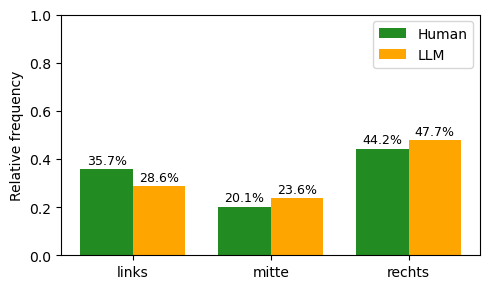

In [ ]:
# Visualizing annotations

x = np.arange(len(labels_order))
width = 0.38

fig, ax = plt.subplots(figsize=(5,3))
ax.bar(x - width/2, human_rel.values, width, label="Human", color="forestgreen")
ax.bar(x + width/2, llm_rel.values, width, label="LLM", color="orange")

ax.set_xticks(x)
ax.set_xticklabels(labels_order)
ax.set_ylim(0, 1)
ax.set_ylabel("Relative frequency")
#ax.set_title("Label distribution: Human vs LLM")
ax.legend()

# annotate with percentages
for xpos, val in zip(x - width/2, human_rel.values):
    ax.text(xpos, val + 0.01, f"{val:.1%}", ha="center", va="bottom", fontsize=9)
for xpos, val in zip(x + width/2, llm_rel.values):
    ax.text(xpos, val + 0.01, f"{val:.1%}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()